# VQE 
## 1. State preparation circuit
Convert |000000> state to an actual state |$\phi(\theta)$> with an arbitary input parameters set $\theta$

[PASS] build: build: ok
[PASS] zero_params_identity: zero-params: distance=0.000e+00
[PASS] param_influence: influence: p0: Δ=1.468e-03, p1: Δ=1.444e-03, p2: Δ=1.483e-03, p3: Δ=1.489e-03, p4: Δ=1.470e-03, p5: Δ=1.391e-03
[PASS] particle_number: particle-number: <N>=3.000000 (expect 3.000000 if conserved)


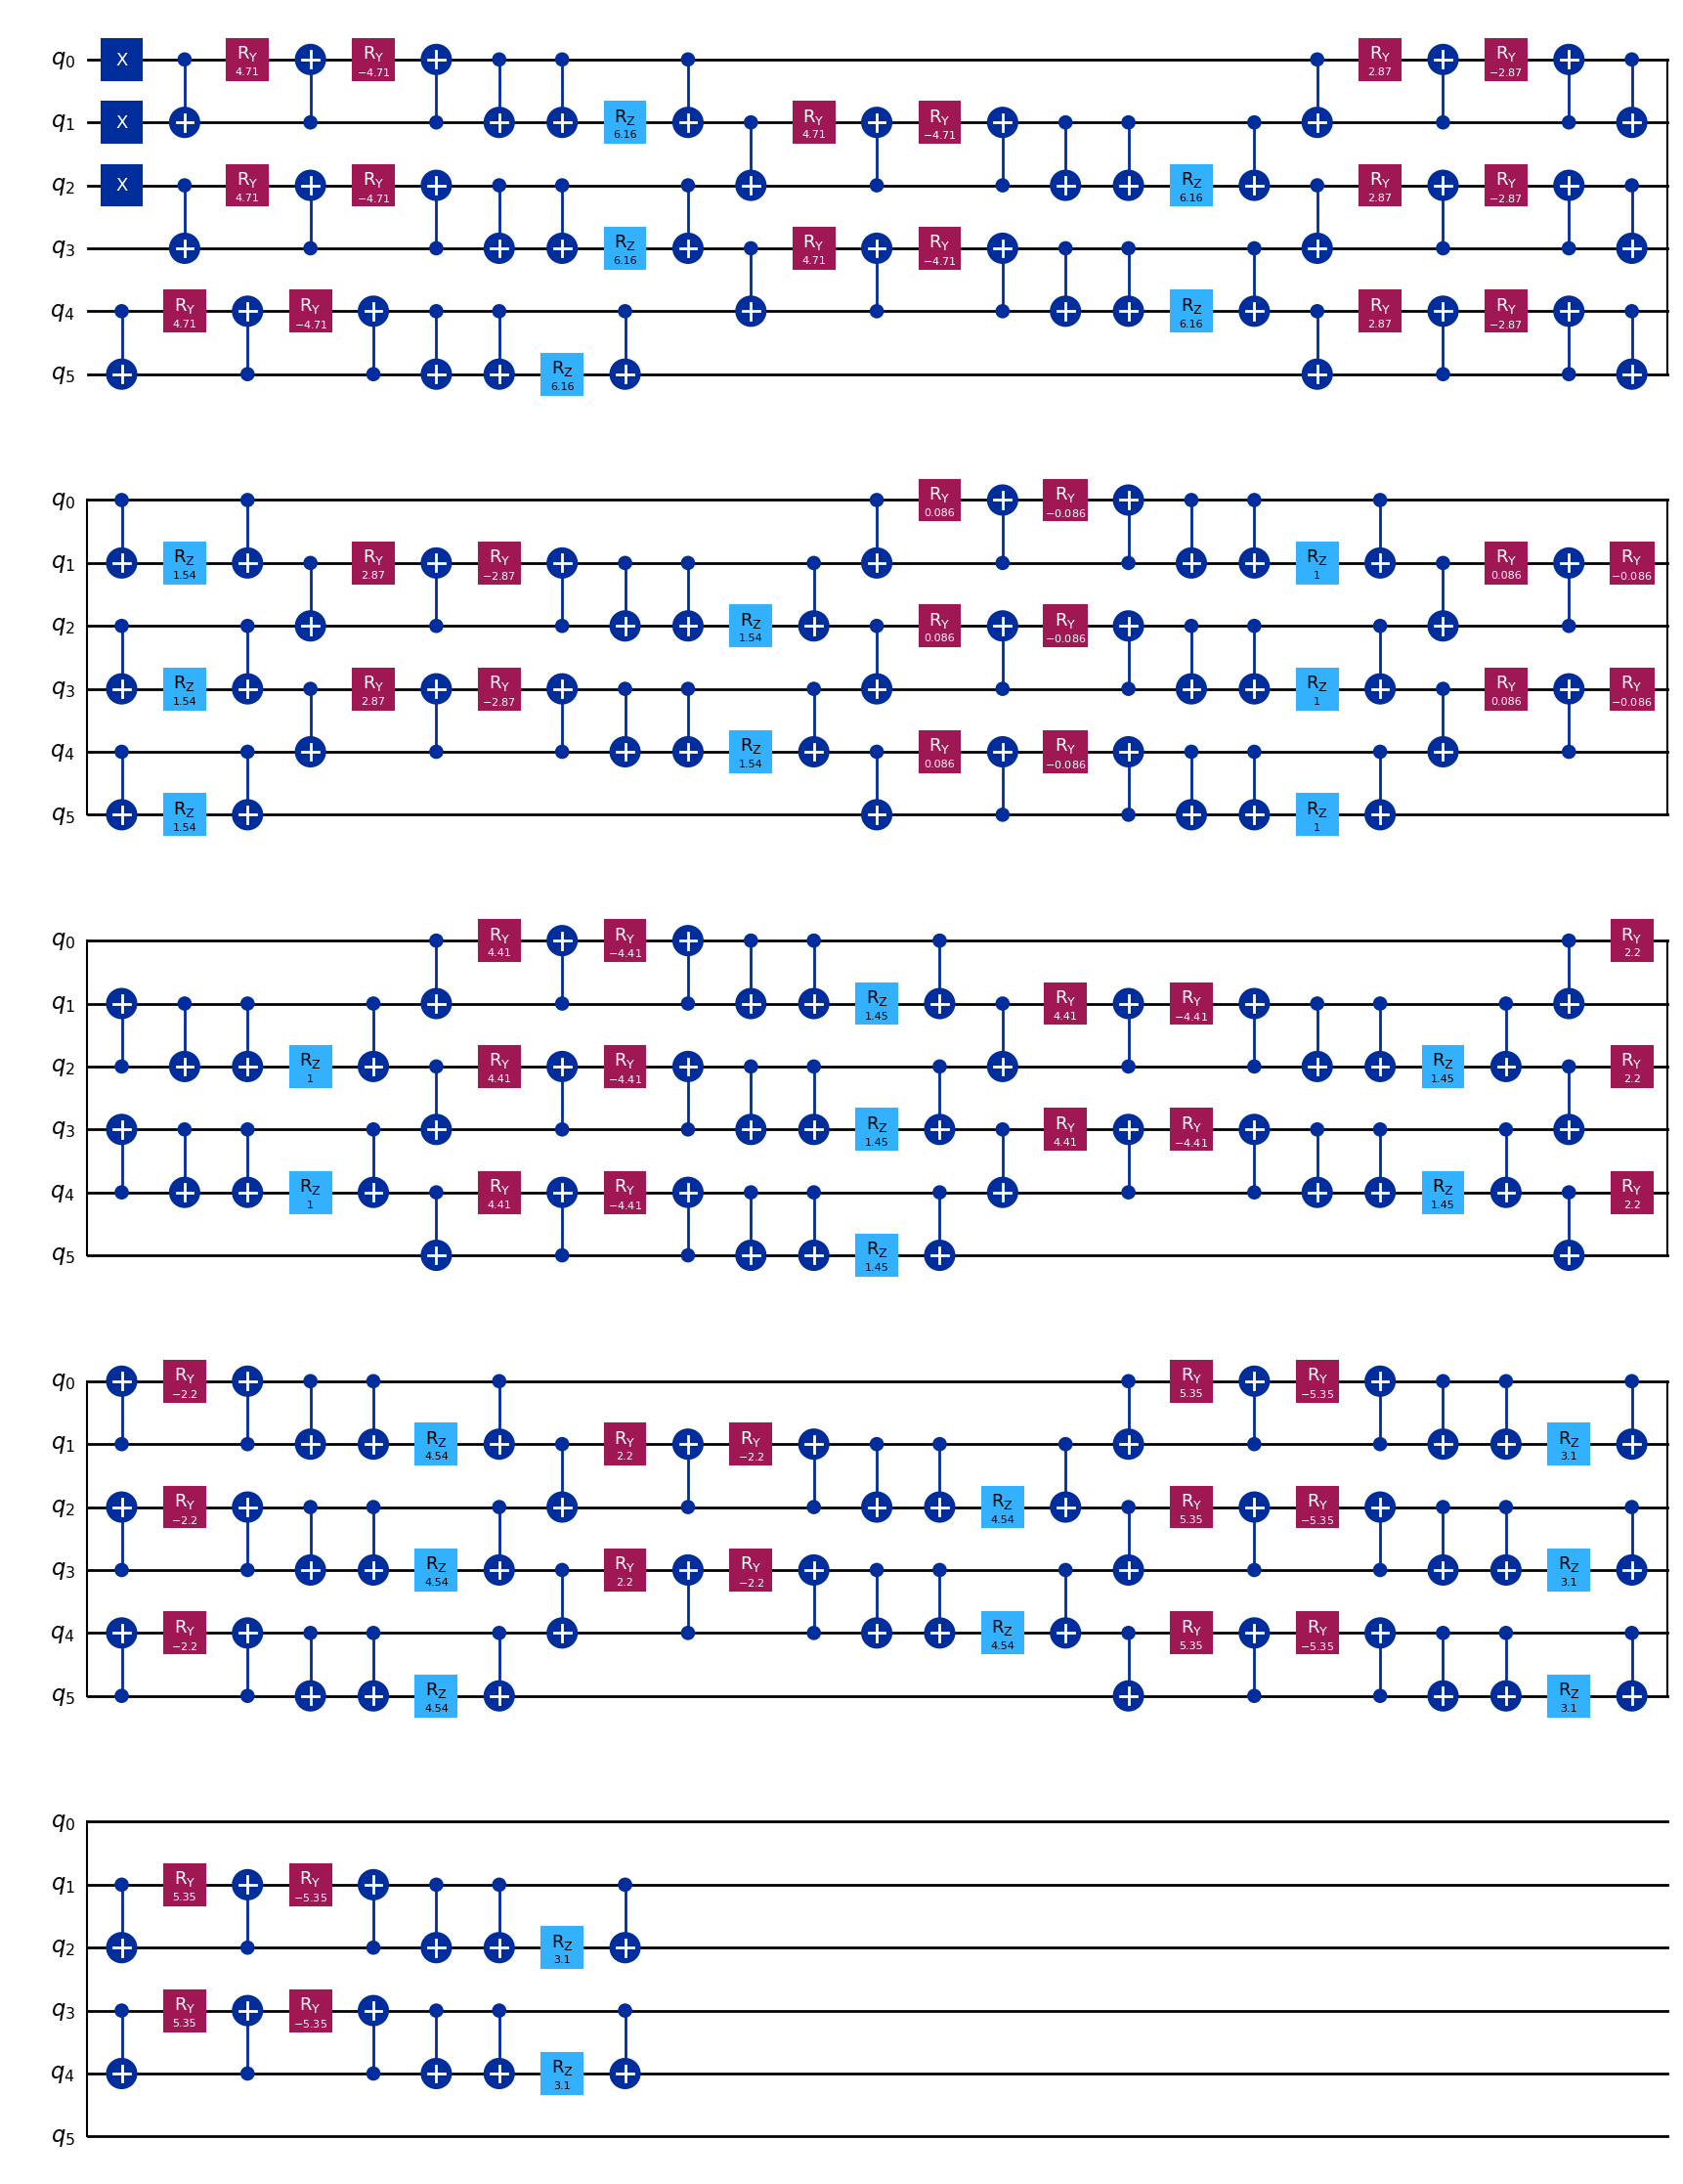

In [40]:
# Define and verify ansatz
import math, random
from typing import Callable, List, Tuple, Optional
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import matplotlib as mpl
import numpy as np



def _build_hf_init(qc, n_qubits: int, n_particles: int):
    # Initialize Hatric-Fork State |000000> -> |111000>
    try:
        i = 0
        while i < n_particles:
            qc.x(i); i += 1
        return qc
    except Exception as e:
        raise RuntimeError(f"HF init build failed: {e}")

def _givens(qc, i: int, j: int, theta: float):
    # Number-conserving SU(2) mixer on modes (i,j).
    # Acts as: |01> -> cos(theta/2)|01> + sin(theta/2)|10>, etc.
    try:
        qc.cx(i, j)
        qc.ry(0.5*theta, i)
        qc.cx(j, i)
        qc.ry(-0.5*theta, i)
        qc.cx(j, i)
        qc.cx(i, j)
    except Exception as e:
        raise RuntimeError(f"Givens({i},{j}) failed: {e}")

def _pair_phase(qc, i: int, j: int, phi: float):
    # Diagonal entangler ~ exp(i*phi * n_i n_j) up to one-body phases.
    try:
        qc.cx(i, j)
        qc.rz(phi, j)
        qc.cx(i, j)
    except Exception as e:
        raise RuntimeError(f"PairPhase({i},{j}) failed: {e}")

def _layer(qc, beta: float, gamma: float, pairs_mix: List[Tuple[int,int]], pairs_zz: List[Tuple[int,int]]):
    # Mix on all chosen pairs with the SAME beta (low-parameter), then ZZ with SAME gamma.
    try:
        k = 0
        while k < len(pairs_mix):
            i, j = pairs_mix[k]
            _givens(qc, i, j, beta)   # beta maps to rotation angle θ
            k = k + 1
        k = 0
        while k < len(pairs_zz):
            i, j = pairs_zz[k]
            _pair_phase(qc, i, j, gamma)
            k = k + 1
    except Exception as e:
        raise RuntimeError(f"layer failed: {e}")

def ansatz(betas: List[float], gammas: List[float]):
    """
    Build p-layer ansatz with parameters betas, gammas (same length).
    Schedule: even-odd brickwork to cover all neighbors with linear depth.
    """
    try:
        from qiskit import QuantumCircuit
    except Exception as e:
        raise RuntimeError(f"Qiskit import failed: {e}")

    if not isinstance(betas, list) or not isinstance(gammas, list):
        raise ValueError("betas/gammas must be lists of floats")
    if len(betas) != len(gammas):
        raise ValueError("betas and gammas must have the same length")
    p = len(betas)
    if p < 1:
        raise ValueError("need at least one layer")

    try:
        qc = QuantumCircuit(6, name="NC-LP")
        _build_hf_init(qc, 6, 3)

        # Even/odd neighbor schedules (parallel-friendly)
        even_pairs = [(0,1), (2,3), (4,5)]
        odd_pairs  = [(1,2), (3,4)]

        L = 0
        while L < p:
            beta = float(betas[L])
            gamma = float(gammas[L])
            _layer(qc, beta,  gamma, even_pairs, even_pairs)  # use same set for mixing and ZZ
            _layer(qc, beta,  gamma, odd_pairs,  odd_pairs)
            L = L + 1
        return qc
    except Exception as e:
        raise RuntimeError(f"make_nc_lowparam_ansatz failed: {e}")

# ---- Tests ----
def test_build(make_fn: Callable[[List[float]], "QuantumCircuit"]):
    try:
        beta = list(np.random.rand(6)*4*np.pi); gamma = list(np.random.rand(6)*2*np.pi); qc = make_fn(beta,gamma)
        from qiskit import QuantumCircuit as QC
        ok = isinstance(qc, QC) and qc.num_qubits == 6
        return ok, ("build: ok" if ok else "build: wrong type or qubit count")
    except Exception as e:
        return False, f"build: exception: {e}"

def test_zero_params_identity(make_fn):
    try:
        beta = [0.0]*6
        gamma = [0.0]*6
        qc = make_fn(beta,gamma); hf = _build_hf_init(qc,6, 3) 
        sv_hf = _statevector_from_circuit(hf); sv_full = _statevector_from_circuit(qc)
        if sv_hf is None or sv_full is None: return False, "zero-params: simulation failed"
        d = _state_distance(sv_hf.data, sv_full.data)
        return (d < 1e-9), f"zero-params: distance={d:.3e}"
    except Exception as e:
        return False, f"zero-params: exception: {e}"

def test_param_influence(make_fn):
    try:
        beta = [1.0]*6; gamma = [0.75]*6; base_qc = make_fn(beta, gamma); sv0 = _statevector_from_circuit(base_qc)
        if sv0 is None: return False, "influence: base simulation failed"
        i = 0; ok = True; details = []
        while i < 6:
            p1 = [1.0]*6; p1[i] += 1e-3
            p2 = [0.75]*6; p2[i] += 1e-3
            sv = _statevector_from_circuit(make_fn(p1,p2))
            if sv is None: return False, "influence: simulation failed"
            d = _state_distance(sv0.data, sv.data)
            if d <= 1e-8: ok = False
            details.append(f"p{i}: Δ={d:.3e}"); i += 1
        return ok, "influence: " + ", ".join(details)
    except Exception as e:
        return False, f"influence: exception: {e}"

def test_particle_number(make_fn):
    try:
        beta = list(np.random.rand(6)*4*np.pi); gamma = list(np.random.rand(6)*2*np.pi)
        sv = _statevector_from_circuit(make_fn(beta,gamma))
        if sv is None: return False, "particle-number: simulation failed"
        N = _particle_number_exp(sv, 6)
        return abs(N-3.0) < 1e-9, f"particle-number: <N>={N:.6f} (expect 3.000000 if conserved)"
    except Exception as e:
        return False, f"particle-number: exception: {e}"


def run_all_tests(make_fn):

    tests = [("build", test_build), ("zero_params_identity", test_zero_params_identity),
             ("param_influence", test_param_influence),
             ("particle_number", test_particle_number)]
    for name, fn in tests:
        ok, msg = fn(make_fn)
        print(f"[{'PASS' if ok else 'FAIL'}] {name}: {msg}")

# Run
run_all_tests(ansatz)
betas = list(np.random.rand(6)*4*np.pi)
gammas = list(np.random.rand(6)*2*np.pi)
qc = ansatz(betas,gammas)
qc.draw(output="mpl")

## 2. Hamiltonian
Take the given Hamiltonian and calculate its expectation value
### 2.1 Define Hamiltonian

In [41]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（ペア＋単粒子遷移含む）
w3 = 0.2      # 3体相互作用

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義 ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン（改訂版）====
pairs = [(0, 1), (2, 3), (4, 5)]
H2 = np.zeros((dim, dim))

def find_pair_and_single(state):
    """3粒子状態から (pair_index, single_orbital) を特定"""
    for p_idx, (a, b) in enumerate(pairs):
        if state[a] == 1 and state[b] == 1:
            s = [i for i in range(len(state)) if state[i] == 1 and i not in (a, b)][0]
            return p_idx, s
    return None, None

# すべてのペア・単粒子遷移を許す
for i, bra in enumerate(basis):
    p_bra, s_bra = find_pair_and_single(bra)
    if p_bra is None:
        continue  # ペアがない状態は作用しない

    for j, ket in enumerate(basis):
        p_ket, s_ket = find_pair_and_single(ket)
        if p_ket is None:
            continue

        # ペアと単粒子の両方が遷移できる
        # 全結合を許して同一強度v
        H2[i, j] += v



# ==== 3体ハミルトニアン（変更なし）====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # アニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # クリエイト
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = (H + H.conj()) / 2  # Hermitian化

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))
print(H)

# ==== 固有値 ====
eigvals, _ = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

print("\nNonzero elements in H2:", np.count_nonzero(H2))

Hamiltonian matrix (dim=20):
[[1.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.3 1.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 2.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 2.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 0.3 2.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.3 0.3 0.3 0.3 0.3 0.  0.  0.  0.  4.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 2.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

### 2.2 Pauli Expansion

In [42]:
import itertools
import numpy as np
from qiskit.quantum_info import SparsePauliOp

# ==== 全基底（64次元） ====
all_basis = [tuple(int(x) for x in format(i, '06b')) for i in range(2**6)]

# ==== 3粒子空間の基底インデックスを求める ====
basis_index = [all_basis.index(b) for b in basis]

# ==== 20次元→64次元への埋め込み ====
H_full = np.zeros((64, 64), dtype=complex)
for i, bi in enumerate(basis_index):
    for j, bj in enumerate(basis_index):
        H_full[bi, bj] = H[i, j]

# ==== パウリ行列定義 ====
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
paulis = [I, X, Y, Z]
labels = ['I','X','Y','Z']

# ==== Pauli 展開 ====
coeffs = {}
for ops in itertools.product(range(4), repeat=6):
    P = paulis[ops[0]]
    for k in ops[1:]:
        P = np.kron(P, paulis[k])
    c = np.trace(P @ H_full) / 64
    if abs(c) > 1e-8:
        label = ''.join(labels[k] for k in reversed(ops))
        coeffs[label] = np.real_if_close(c)

# ==== 出力 ====


#print(f"\nNonzero Pauli terms ({len(coeffs)} terms):")
#for k, v in sorted(coeffs.items(), key=lambda x: -abs(x[1])):
#    print(f"{k:10s} : {v:.6f}")

hamiltonian_op = SparsePauliOp(list(coeffs.keys()),np.array(list(coeffs.values())))

### 2.3 Estimate Hamiltonian Expectation Value

In [44]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
job = estimator.run([(qc, hamiltonian_op, )])
hamiltonion_result = job.result()
E_meas = hamiltonion_result[0].data.evs
print("E_meas: ", E_meas)

E_meas:  3.240558450068378


In [48]:
import numpy as np
from typing import List, Optional



# ---------- Expectation with dense H_full ----------
def expval_dense(H_full: np.ndarray, psi_big: np.ndarray) -> complex:
    try:
        if H_full.ndim != 2 or H_full.shape[0] != H_full.shape[1]:
            raise ValueError("H_full must be a square matrix")
        if H_full.shape[0] != len(psi_big):
            raise ValueError("shape mismatch between H_full and psi")
        # Compute psi^† (H psi) without reshape
        Hv = H_full @ psi_big
        acc = 0.0 + 0.0j
        i = 0
        while i < len(psi_big):
            acc = acc + np.conjugate(psi_big[i]) * Hv[i]
            i = i + 1
        return acc
    except Exception as e:
        raise RuntimeError(f"expval_dense failed: {e}")

# ---------- Build state from ansatz ----------
def state_from_ansatz(make_fn, beta: List[float],gamma :List[float], n_qubits: int) -> np.ndarray:
    try:
        from qiskit.quantum_info import Statevector
    except Exception as e:
        raise RuntimeError(f"Qiskit not available: {e}")
    try:
        qc = make_fn(beta,gamma)  # your ansatz builder -> QuantumCircuit
        sv = Statevector.from_instruction(qc)
        return np.array(sv.data, dtype=complex)
    except Exception as e:
        raise RuntimeError(f"state_from_ansatz failed: {e}")

# ---------- Optional: expectation via SparsePauliOp ----------
def expval_sparsepauli(hamiltonian_op, make_fn, beta: List[float],gamma :List[float]) -> complex:
    try:
        from qiskit.quantum_info import Statevector, Operator
    except Exception as e:
        raise RuntimeError(f"Qiskit not available: {e}")
    try:
        sv = Statevector.from_instruction(make_fn(beta,gamma))
        # Convert to Operator to avoid endianness confusion in manual apply
        op = Operator(hamiltonian_op)
        val = sv.expectation_value(op)
        return complex(val)
    except Exception as e:
        raise RuntimeError(f"expval_sparsepauli failed: {e}")


In [49]:
# Compare expectation value of dense matrix and SparsePauliOp
betas = [0.6, 0.9, 0.7, 0.8, 0.4, 1.1]
gammas = [0.1, 0.3, 0.5, 0.6, 0.8, 1.0]
psi = state_from_ansatz(ansatz, betas, gammas, n_qubits=6)

# Expectation with dense matrix
E_dense = expval_dense(H_full, psi)
print("E (dense) =", float(np.real(E_dense)))

# Expectation via SparsePauliOp (ensure labels are built in Qiskit’s convention!)
E_sp = expval_sparsepauli(hamiltonian_op, ansatz, betas, gammas)
print("E (SparsePauliOp) =", float(np.real(E_sp)))


E (dense) = 4.926031542222295
E (SparsePauliOp) = 4.926031542222296


## 3. Optimization
Optimize agianst $\theta$

## 4. Repeat
Repeat and output result